<a href="https://colab.research.google.com/github/gks4478/section2_project/blob/main/%EC%84%B9%EC%85%982_%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

0. 파일 불러오기

In [ ]:
import pandas as pd
df = pd.read_csv('mussorie_reviews.csv')

1. 라이브러리 설치

In [ ]:
# nltk 설치
%pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import string
import re
import nltk
from nltk.corpus import stopwords as StopWords
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, log_loss
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# nltk 다운로드
nltk.download('treebank')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\82109\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\82109\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\82109\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

2. 전처리, 특성공학

In [ ]:
# 1. 결측치 삭제
df.dropna(inplace = True)

In [ ]:
# 2. 중복값 삭제
df.drop_duplicates(inplace = True)

In [ ]:
# 3. Rating에서 평점만 가져오기
df['Rating'] = df['Rating'].apply(lambda x: re.findall('\d', x)[0])

In [ ]:
# 4. 평점의 5점, 4점은 1(positive) 나머지는 0(negative)로 설정한다.
df["Sentiment"] = df["Rating"].map({"5":"Positive", "4":"Positive", "3":"Neutral", "2":"Negative", "1":"Negative"})

In [ ]:
# 5. year
df["Year of stay"] = df["Date of stay"].apply(lambda x: "".join(re.findall("\d\d\d\d", x)))

In [ ]:
# 6. month
df["Month of stay"] = df["Date of stay"].apply(lambda x: "".join(re.findall(r'(Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?)', x)))

In [ ]:
# 7. 2018년 미만 삭제
df.drop(df[df["Year of stay"] < '2018'].index, axis=0, inplace=True)

In [ ]:
# 8. Neutral 삭제
df.drop(df[df["Sentiment"] == "Neutral"].index, axis=0, inplace=True,)

In [ ]:
# 9. 인덱스 리셋
df = df.reset_index()
df = df.drop('index', axis = 1)

In [ ]:
# 10. 섞기
df = df.sample(frac = 1)
df

,Review,Date of stay,Rating,Sentiment,Year of stay,Month of stay
5085,This hotal is beautiful..we stay here..our sta...,Date of stay: April 2021,5,Positive,2021,April
1588,This was my first time to mussoorrie and the t...,Date of stay: May 2019,5,Positive,2019,May
5058,"It was torturous, landlines don’t work, so man...",Date of stay: July 2021,1,Negative,2021,July
7774,Nice hotel..!!! It was fun to stay here .Servi...,Date of stay: November 2018,4,Positive,2018,November
7575,"Location is nice, peaceful and easy approachab...",Date of stay: April 2019,5,Positive,2019,April
...,...,...,...,...,...,...
2665,Amazing property with amazing staff especially...,Date of stay: March 2018,5,Positive,2018,March
1833,Went for my first anniversary. Had earlier gon...,Date of stay: February 2019,5,Positive,2019,February
2311,We were here in the property for three nights ...,Date of stay: August 2018,5,Positive,2018,August
400,I don't have words to Express my immense grati...,Date of stay: February 2021,5,Positive,2021,February


In [ ]:
# 11. 불필요한 컬럼 삭제 
df.drop(['Date of stay', 'Rating'], axis=1, inplace=True)

In [ ]:
# 12. review
def preprocess_data(text):
    """
    Returns text after removing numbers, punctuations, urls, emojis, html tags and lowercasing all the words in given text.
    """
    text = re.sub(r'[0-9]+', '', str(text))   # removing numbers
    text = re.sub(r'[^\w\s]', '', str(text))   # removing punctuations
    text = " ".join(x.lower() for x in text.split())  # lower casing the text
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # removing urls
    text = re.sub(r'<.*?>', '', text) # removing html tags
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    text = " ".join(x for x in text.split() if x not in StopWords.words('english'))
    return text

In [ ]:
# 13. 리뷰 정제 
df["Preprocessed_reviews"] = df["Review"].apply(lambda x: preprocess_data(x))

In [ ]:
df

,Review,Sentiment,Year of stay,Month of stay,Preprocessed_reviews
5085,This hotal is beautiful..we stay here..our sta...,Positive,2021,April,hotal beautifulwe stay hereour stay awesome be...
1588,This was my first time to mussoorrie and the t...,Positive,2019,May,first time mussoorrie trip quite memory must s...
5058,"It was torturous, landlines don’t work, so man...",Negative,2021,July,torturous landlines dont work many stairs cros...
7774,Nice hotel..!!! It was fun to stay here .Servi...,Positive,2018,November,nice hotel fun stay services great staff membe...
7575,"Location is nice, peaceful and easy approachab...",Positive,2019,April,location nice peaceful easy approachable rooms...
...,...,...,...,...,...
2665,Amazing property with amazing staff especially...,Positive,2018,March,amazing property amazing staff especially saga...
1833,Went for my first anniversary. Had earlier gon...,Positive,2019,February,went first anniversary earlier gone sisters en...
2311,We were here in the property for three nights ...,Positive,2018,August,property three nights stay best would like spe...
400,I don't have words to Express my immense grati...,Positive,2021,February,dont words express immense gratitude imran ji ...


In [ ]:
# 14. 단어 개수 세기
df["Word_count"] = df["Review"].apply(lambda x: len(str(x).split()))

In [ ]:
# 15. 특별한 단어 개수 세기
df["Unique_word_count"] = df["Review"].apply(lambda x: len(set(str(x).split())))

In [ ]:
# 16. 불용어 개수 세기
stop_words = StopWords.words('english')
df["Stopword_count"] = df["Review"].apply(lambda x: len([w for w in str(x).lower().split() if w not in stop_words]))

In [ ]:
# 17. 한 단어당 알파벳 글자 개수 평균
df["Mean_word_length"] = df["Review"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [ ]:
# 18. 총 문자의 개수
df["Char_count"] = df["Review"].apply(lambda x: len(str(x)))

In [ ]:
# 19. 구두점 개수 세기
df["Punctuation_count"] = df["Review"].apply(lambda x: len([p for p in str(x) if p in string.punctuation]))
df.head()

,Review,Sentiment,Year of stay,Month of stay,Preprocessed_reviews,Word_count,Unique_word_count,Stopword_count,Mean_word_length,Char_count,Punctuation_count
5085,This hotal is beautiful..we stay here..our sta...,Positive,2021,April,hotal beautifulwe stay hereour stay awesome be...,36,32,26,5.638889,238,15
1588,This was my first time to mussoorrie and the t...,Positive,2019,May,first time mussoorrie trip quite memory must s...,155,97,75,4.096774,790,9
5058,"It was torturous, landlines don’t work, so man...",Negative,2021,July,torturous landlines dont work many stairs cros...,37,35,24,4.702703,211,9
7774,Nice hotel..!!! It was fun to stay here .Servi...,Positive,2018,November,nice hotel fun stay services great staff membe...,45,38,26,4.711111,256,11
7575,"Location is nice, peaceful and easy approachab...",Positive,2019,April,location nice peaceful easy approachable rooms...,32,29,22,5.531250,208,7


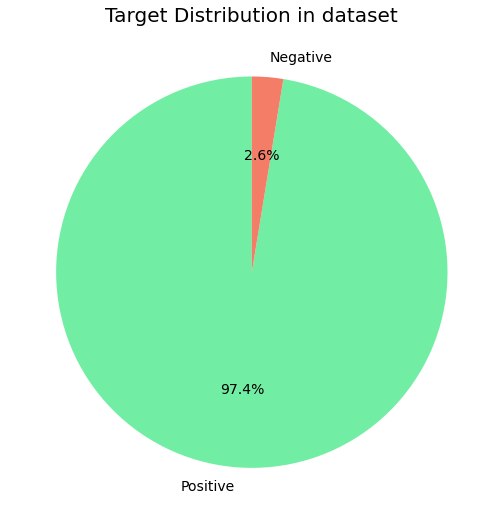

In [ ]:
# 타겟 균형도
plt.figure(figsize=(9, 9))
s = df['Sentiment'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, fontsize=14, colors=['#72EEA4', '#F37D67']);
s.set_ylabel('');
s.set_title('Target Distribution in dataset', fontsize=20);

In [ ]:
def generate_ngrams(text, n_gram=1):
    """
    Returns ngrams for the given text.
    
    Parameters:
    text : for which we want ngrams
    n_gram : value for ngram
    """
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

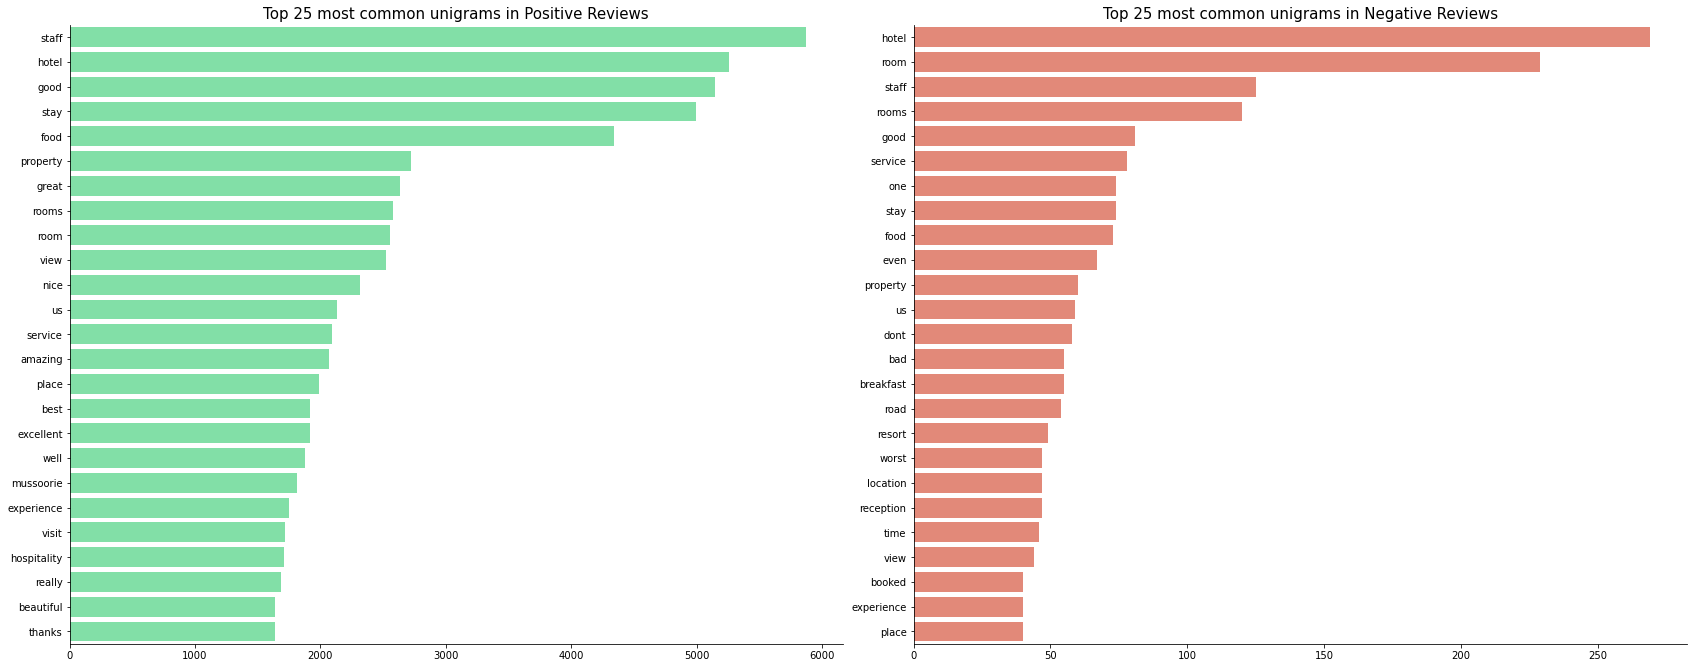

In [ ]:
positive_unigrams = defaultdict(int)
negative_unigrams = defaultdict(int)

# Number of ngrams we want
N = 25

# Loop for updating value of positive_unigrams
for review in df['Preprocessed_reviews'][df['Sentiment']=="Positive"]:
    for word in generate_ngrams(review):
        positive_unigrams[word] += 1

for review in df['Preprocessed_reviews'][df['Sentiment']=="Negative"]:
    for word in generate_ngrams(review):
        negative_unigrams[word] += 1
        
# Creating dataframes using default dictionaries
df_positive_unigrams = pd.DataFrame(sorted(positive_unigrams.items(), key=lambda x: x[1])[::-1])
df_negative_unigrams = pd.DataFrame(sorted(negative_unigrams.items(), key=lambda x: x[1])[::-1])

        
fig, axes = plt.subplots(ncols=2, figsize=(24, 10))
plt.tight_layout(pad=4.0)

# Plotting positive and negative unigrams dataset
sns.despine()
sns.barplot(y = df_positive_unigrams[0].values[:N], x = df_positive_unigrams[1].values[:N], ax=axes[0], color='#72EEA4')
sns.barplot(y = df_negative_unigrams[0].values[:N], x = df_negative_unigrams[1].values[:N], ax=axes[1], color='#F37D67')

axes[0].set_title(f'Top {N} most common unigrams in Positive Reviews', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in Negative Reviews', fontsize=15)

plt.show()

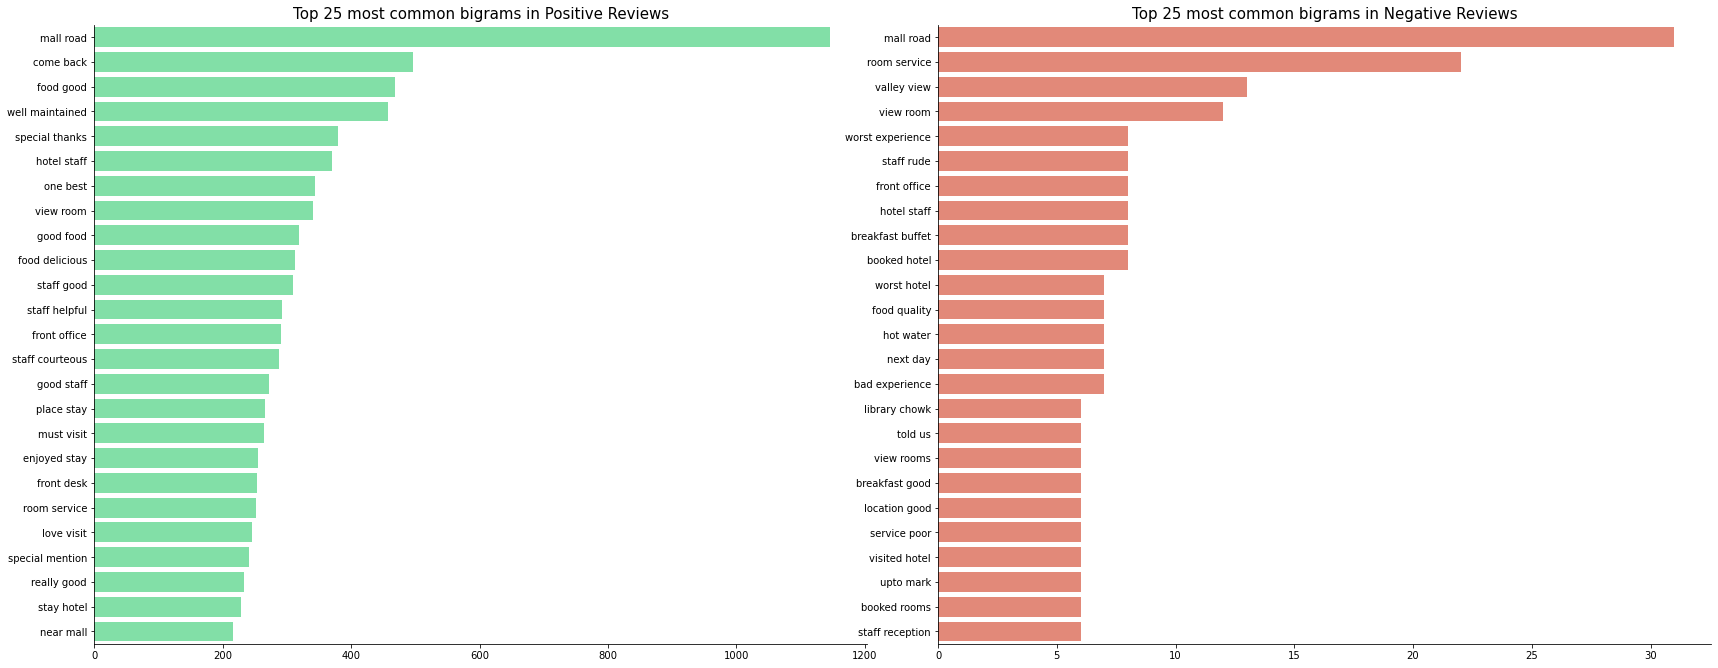

In [ ]:
positive_bigrams = defaultdict(int)
negative_bigrams = defaultdict(int)

# Number of ngrams we want
N = 25

# Loop for updating values of bigrams in default dictionary
for review in df['Preprocessed_reviews'][df['Sentiment']=="Positive"]:
    for word in generate_ngrams(review, n_gram=2):
        positive_bigrams[word] += 1

for review in df['Preprocessed_reviews'][df['Sentiment']=="Negative"]:
    for word in generate_ngrams(review, n_gram=2):
        negative_bigrams[word] += 1
        
# Creating a dataset using default dictionaries
df_positive_bigrams = pd.DataFrame(sorted(positive_bigrams.items(), key=lambda x: x[1])[::-1])
df_negative_bigrams = pd.DataFrame(sorted(negative_bigrams.items(), key=lambda x: x[1])[::-1])
        
fig, axes = plt.subplots(ncols=2, figsize=(24, 10))
plt.tight_layout(pad=4.0)
 
# Plotting both positive and negative bigrams
sns.despine()
sns.barplot(y = df_positive_bigrams[0].values[:N], x = df_positive_bigrams[1].values[:N], ax=axes[0], color='#72EEA4')
sns.barplot(y = df_negative_bigrams[0].values[:N], x = df_negative_bigrams[1].values[:N], ax=axes[1], color='#F37D67')

axes[0].set_title(f'Top {N} most common bigrams in Positive Reviews', fontsize=15)
axes[1].set_title(f'Top {N} most common bigrams in Negative Reviews', fontsize=15)

plt.show()

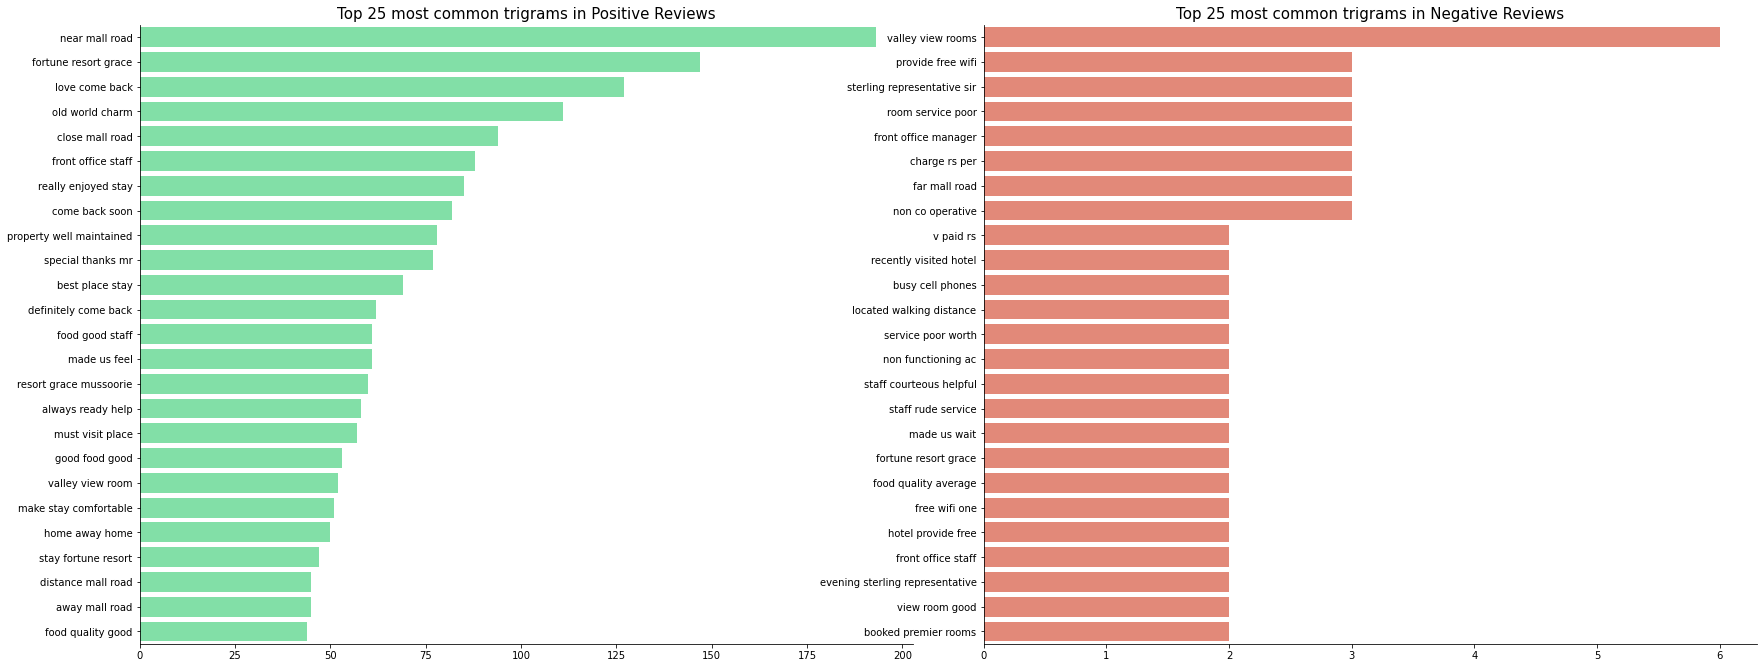

In [ ]:
positive_trigrams = defaultdict(int)
negative_trigrams = defaultdict(int)

# Number of ngrams we want
N = 25

# Loop for updating default dictionaries 
for review in df['Preprocessed_reviews'][df['Sentiment']=="Positive"]:
    for word in generate_ngrams(review, n_gram=3):
        positive_trigrams[word] += 1

for review in df['Preprocessed_reviews'][df['Sentiment']=="Negative"]:
    for word in generate_ngrams(review, n_gram=3):
        negative_trigrams[word] += 1
        
# Creating a dataframe using dictionaries
df_positive_trigrams = pd.DataFrame(sorted(positive_trigrams.items(), key=lambda x: x[1])[::-1])
df_negative_trigrams = pd.DataFrame(sorted(negative_trigrams.items(), key=lambda x: x[1])[::-1])
        
fig, axes = plt.subplots(ncols=2, figsize=(24, 10))
plt.tight_layout(pad=4.0)
     
# Plotting positive and negative trigrams
sns.despine()
sns.barplot(y = df_positive_trigrams[0].values[:N], x = df_positive_trigrams[1].values[:N], ax=axes[0], color='#72EEA4')
sns.barplot(y = df_negative_trigrams[0].values[:N], x = df_negative_trigrams[1].values[:N], ax=axes[1], color='#F37D67')

axes[0].set_title(f'Top {N} most common trigrams in Positive Reviews', fontsize=15)
axes[1].set_title(f'Top {N} most common trigrams in Negative Reviews', fontsize=15)

plt.show()

In [ ]:
# Create custom stop words
all_text = " ".join(list(df["Preprocessed_reviews"]))
words = pd.Series(all_text.split(" "))
frequent_words = words.value_counts()[:20]

In [ ]:
df["Preprocessed_reviews"] = df["Preprocessed_reviews"].apply(lambda x: " ".join([word for word in str(x).split() if word not in frequent_words]))

In [ ]:
le = LabelEncoder()
df['Sentiment'] = le.fit_transform(df['Sentiment'])

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(df['Review'], df['Sentiment'], 
                                                  stratify=df['Sentiment'], 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)

In [ ]:
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, 
                                                  stratify=ytrain, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)

In [ ]:
# Initializing TfidfVectorizer
tfv = TfidfVectorizer(min_df=3,  max_features=None, decode_error = "replace", preprocessor = preprocess_data,
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

# Fitting Tfidf vectorizer to training dataset
tfv.fit(list(xtrain))

# Transforming the training and validation dataset 
xtrain_tfv = tfv.transform(xtrain)
xval_tfv = tfv.transform(xval)

In [ ]:
from imblearn.over_sampling import SMOTE

xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, max_depth=4, subsample= 1.0, min_child_weight=1, gamma= 0.5, colsample_bytree= 0.8, random_state=42)

x_train_sampled, y_train_sampled = SMOTE(random_state = 42).fit_resample(
    xtrain_tfv, ytrain
)

watchlist = [(x_train_sampled, y_train_sampled), (xval_tfv, yval)]

# Fitting xgb on training dataset
xgb.fit(x_train_sampled, y_train_sampled, eval_set = watchlist, early_stopping_rounds=50,)

# Making predictions on validation dataset
predictions = xgb.predict_proba(xval_tfv)
print ("logloss: %0.3f " % log_loss(yval, predictions))

ypred_xg = xgb.predict(xval_tfv)
print(classification_report(yval, ypred_xg))

[0]	validation_0-logloss:0.67945	validation_1-logloss:0.67914
[1]	validation_0-logloss:0.66635	validation_1-logloss:0.66574
[2]	validation_0-logloss:0.65446	validation_1-logloss:0.65395
[3]	validation_0-logloss:0.64209	validation_1-logloss:0.64121
[4]	validation_0-logloss:0.63018	validation_1-logloss:0.62903
[5]	validation_0-logloss:0.61964	validation_1-logloss:0.61881
[6]	validation_0-logloss:0.60860	validation_1-logloss:0.60732
[7]	validation_0-logloss:0.59776	validation_1-logloss:0.59615
[8]	validation_0-logloss:0.58824	validation_1-logloss:0.58666
[9]	validation_0-logloss:0.57809	validation_1-logloss:0.57597
[10]	validation_0-logloss:0.56797	validation_1-logloss:0.56651
[11]	validation_0-logloss:0.55839	validation_1-logloss:0.55686
[12]	validation_0-logloss:0.54966	validation_1-logloss:0.54784
[13]	validation_0-logloss:0.54065	validation_1-logloss:0.53889
[14]	validation_0-logloss:0.53195	validation_1-logloss:0.52990
[15]	validation_0-logloss:0.52351	validation_1-logloss:0.52178
[1

In [ ]:
def summarize_results(model, X_val_encoded, y_val):
    # 1. Train / Val Loss Plot
    if isinstance(model, XGBClassifier):
        results = model.evals_result()
        tgts = results["validation_0"].keys()

        for tgt in tgts:
            train_error = results["validation_0"][tgt]
            val_error = results["validation_1"][tgt]

            plt.plot(train_error, label="Train")
            plt.plot(val_error, label="Validation")
            plt.ylabel(tgt)
            plt.xlabel("Model Complexity (n_estimators)")
            plt.legend()
            plt.show()

    # 2. Accuracy / Classification Report
    print("검증 정확도", model.score(X_val_encoded, y_val))

    if isinstance(model, XGBClassifier):
        y_pred = model.predict(X_val_encoded, iteration_range=(0, model.best_iteration))
    else:
        y_pred = model.predict(X_val_encoded)

    print(classification_report(y_val, y_pred))

    # 3. ROC-AUC
    get_roc_auc(model, X_val_encoded, y_val)

    # 4. Confusion Matrix
    ConfusionMatrixDisplay.from_estimator(model, X_val_encoded, y_val,cmap='Blues')
    plt.show()

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score


def get_roc_auc(model, X_val_encoded, y_val):
    if isinstance(model, XGBClassifier):
        y_pred_proba = model.predict_proba(
            X_val_encoded, iteration_range=(0, model.best_iteration)
        )[:, 1]
    else:
        y_pred_proba = model.predict_proba(X_val_encoded)[:, 1]

    print("ROC-AUC:", roc_auc_score(y_val, y_pred_proba))

    baseline_fpr, baseline_tpr, _ = roc_curve(y_val, [0] * len(y_val))
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
    tmp = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thresholds': thresholds})
    plt.plot(baseline_fpr, baseline_tpr, linestyle="--", color="green", label="Baseline"
    )
    plt.plot(fpr, tpr, color="blue", label="Model")
    plt.scatter(fpr, tpr, color="red")
    plt.legend()
    plt.title("ROC curve")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.show()
    return tmp

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


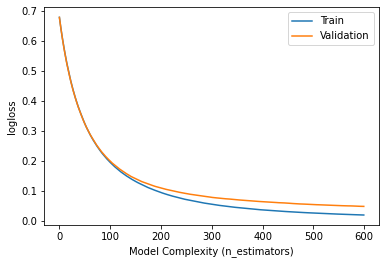

검증 정확도 0.983433734939759
              precision    recall  f1-score   support

           0       0.80      0.47      0.59        17
           1       0.99      1.00      0.99       647

    accuracy                           0.98       664
   macro avg       0.89      0.73      0.79       664
weighted avg       0.98      0.98      0.98       664

ROC-AUC: 0.9689062642058369


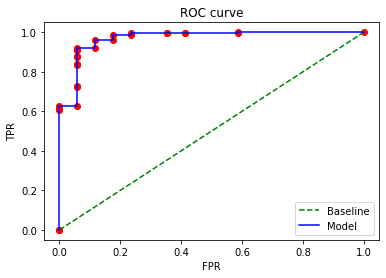

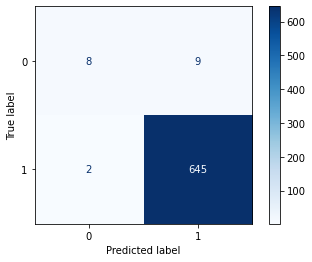

In [ ]:
summarize_results(xgb, xval_tfv, yval)

In [ ]:
# Transfroming test dataset using the same tfidf vectorizer we fit on training dataset
xtest_tfv = tfv.transform(xtest)

In [ ]:
predictions = xgb.predict_proba(xtest_tfv)
print ("logloss: %0.3f " % log_loss(ytest, predictions))
ypred_xg = xgb.predict(xtest_tfv)
print(classification_report(ytest, ypred_xg))

logloss: 0.049 
              precision    recall  f1-score   support

           0       0.88      0.49      0.63        43
           1       0.99      1.00      0.99      1616

    accuracy                           0.98      1659
   macro avg       0.93      0.74      0.81      1659
weighted avg       0.98      0.98      0.98      1659

